### Architecture idea (SIMPLE DIAGRAM)

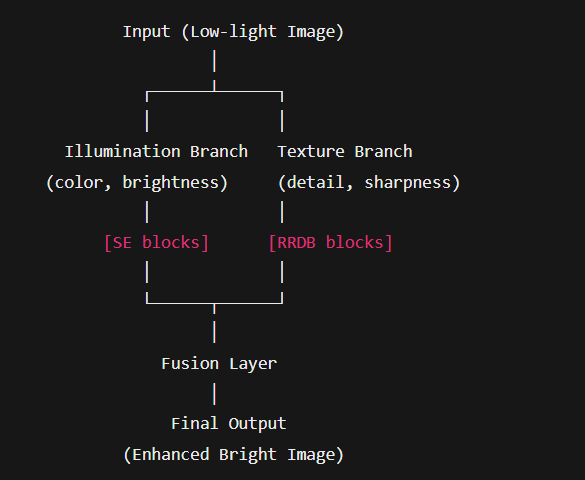

In [1]:
!pip install numpy
!pip install torchmetrics
!pip install piq
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [1]:
import os
import random
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchmetrics import PeakSignalNoiseRatio as PSNR, StructuralSimilarityIndexMeasure as SSIM
from piq import LPIPS
import os
import torch.nn.functional as F
from torchvision.models import vgg19
from torchvision.utils import save_image
from torchvision.datasets import DatasetFolder
from datetime import datetime
from sklearn.model_selection import train_test_split

In [2]:
# def set_seed(seed=42):
#     """Set all random seeds for reproducibility."""
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)  # if using multi-GPU
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

# # Set the seed (choose any number you like)
# set_seed(42) 

# Run Data

In [3]:
dataset_path1 = '/home/tdiykanba2/codes/RRDB_SE_CHECKPOINTS_gaussian_blur/augmented_images'
train_path = f'{dataset_path1}/train'
val_path = f'{dataset_path1}/val'
test_path = f'{dataset_path1}/test'

In [4]:
target_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [5]:
class CleanDataset(Dataset):
    def __init__(self, root_dir, target_transform=None):
        self.root_dir = root_dir
        self.target_transform = target_transform
        self.low_dir = os.path.join(root_dir, "low")
        self.high_dir = os.path.join(root_dir, "high")
        self.image_names = sorted(os.listdir(self.low_dir))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        low_img_path = os.path.join(self.low_dir, self.image_names[idx])
        high_img_path = os.path.join(self.high_dir, self.image_names[idx])

        low_img = Image.open(low_img_path).convert("RGB")
        high_img = Image.open(high_img_path).convert("RGB")

        if self.target_transform:
            low_img = self.target_transform(low_img)
            high_img = self.target_transform(high_img)
            
            
        low_filename = os.path.basename(low_img_path)
        high_filename = os.path.basename(high_img_path)
        
        return low_img, high_img, low_filename, high_filename

train_dataset = CleanDataset(
    root_dir=train_path, 
    target_transform = target_transform
)

val_dataset = CleanDataset(
    root_dir=val_path,
    target_transform = target_transform
)

test_dataset = CleanDataset(root_dir=test_path, target_transform = target_transform)

In [6]:
batch_size=8

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True   # Speeds up transfer to GPU
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,         # No need for validation
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,       # Often use batch_size=1 for testing
    shuffle=False,
    num_workers=1
)

In [7]:
def show_true_images(low_batch, high_batch, n=4):

    """
    Shows EXACTLY what's in your dataset with correct color handling.
    Works for both normalized and unnormalized images.
    """

    plt.figure(figsize=(18, 8))

    for i in range(min(n, len(low_batch))):
        # --- Low-light ---
        plt.subplot(2, n, i+1)
        low_img = low_batch[i].permute(1, 2, 0).numpy()

        # Handle normalization if present
        if low_img.min() < 0:  # Likely normalized
            low_img = (low_img * 0.5 + 0.5)  # Reverse imagenet norm

        # Ensure proper image range
        low_img = np.clip(low_img, 0, 1)
        plt.imshow(low_img)
        plt.title(f"Low")
        plt.axis('off')

        # --- Normal-light ---
        plt.subplot(2, n, n+i+1)
        high_img = high_batch[i].permute(1, 2, 0).numpy()

        if high_img.min() < 0:  # Likely normalized
            high_img = (high_img * 0.5 + 0.5)

        high_img = np.clip(high_img, 0, 1)
        plt.imshow(high_img)
        plt.title(f"High")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Low resolution file name: ['477.png', '734.png', '544.png', '773.png', '745.png', '494.png', '747.png', '564.png']
High resolution file name: ['477.png', '734.png', '544.png', '773.png', '745.png', '494.png', '747.png', '564.png']


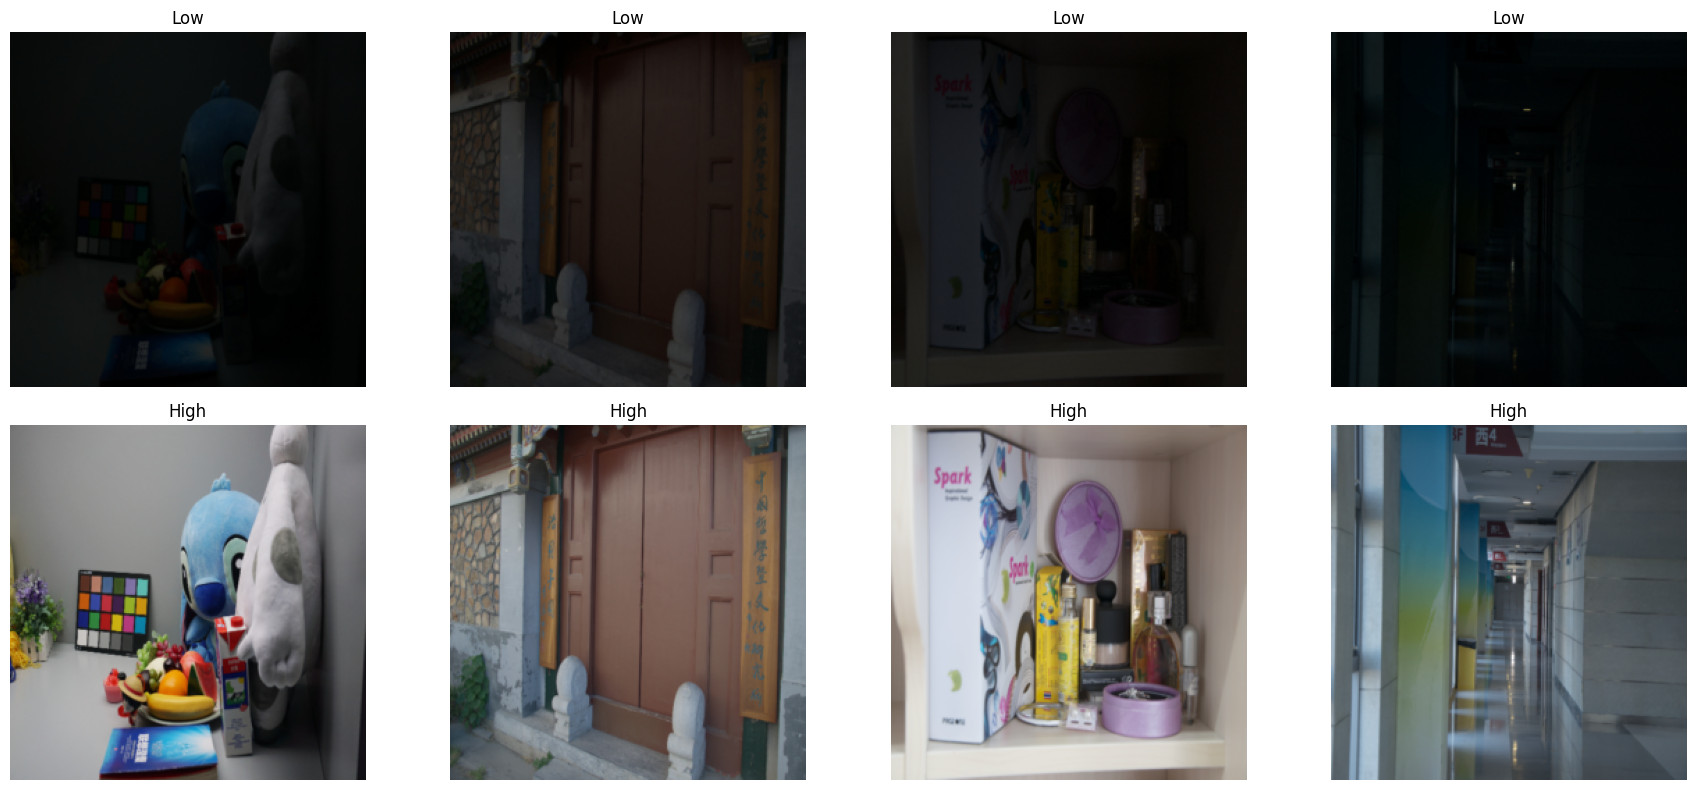

In [8]:
low, high, low_filename, high_filename = next(iter(train_loader))
print("Low resolution file name:", low_filename)
print("High resolution file name:", high_filename)
show_true_images(low, high)

# MODEL ARCHITECTURE

In [9]:
#SE Blocks:

class SEBlock(nn.Module):
    """Squeeze-and-Excitation block for channel attention"""

    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


# Residual-in-Residual Dense Block (RRDB)

class RRDB(nn.Module):
    """Residual-in-Residual Dense Block"""
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.conv2 = nn.Conv2d(channels*2, channels, 3, padding=1)
        self.conv3 = nn.Conv2d(channels*3, channels, 3, padding=1)
        self.lrelu = nn.LeakyReLU(0.2)
        self.se = SEBlock(channels)

    def forward(self, x):
        out1 = self.lrelu(self.conv1(x))
        out2 = self.lrelu(self.conv2(torch.cat([x, out1], 1)))
        out3 = self.conv3(torch.cat([x, out1, out2], 1))
        return self.se(out3 * 0.2 + x)  # Residual scaling


Generator


In [10]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        # Illumination Branch (color/brightness)
        self.illum_conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.illum_rrdb = nn.Sequential(*[RRDB(32) for _ in range(4)])
        self.illum_conv2 = nn.Conv2d(32, 3, 3, padding=1)

        # Texture Branch (detail/sharpness)
        self.texture_conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.texture_rrdb = nn.Sequential(*[RRDB(64) for _ in range(6)])
        self.texture_conv2 = nn.Conv2d(64, 3, 3, padding=1)

        # Fusion
        self.fusion = nn.Sequential(
            nn.Conv2d(6, 32, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 3, 3, padding=1),
            nn.Tanh()  # Output in [-1,1] -> remap to [0,1] later
        )

    def forward(self, x):
        # Illumination path
        illum = self.illum_conv1(x)
        illum = self.illum_rrdb(illum)
        illum = torch.sigmoid(self.illum_conv2(illum))  # [0,1]

        # Texture path
        texture = self.texture_conv1(x)
        texture = self.texture_rrdb(texture)
        texture = self.texture_conv2(texture)  # No activation (keep details)

        # Fusion
        fused = self.fusion(torch.cat([illum, texture], 1))
        return (fused + 1) / 2  # Map to [0,1]

Discriminator

In [11]:
class Discriminator(nn.Module):
    """PatchGAN discriminator"""
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # Input: 3 x 256 x 256
            nn.Conv2d(3, 64, 4, stride=2, padding=1),  # 128
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # 64
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),  # 32
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, stride=1, padding=1),  # 31
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, 4, stride=1, padding=1)  # 30x30 patch output
        )

    def forward(self, x):
        return self.model(x)

Loss Functions


In [12]:
class GANLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.BCEWithLogitsLoss()

    def forward(self, pred, target_is_real):
        target = torch.ones_like(pred) if target_is_real else torch.zeros_like(pred)
        return self.loss(pred, target)


class PerceptualLoss(nn.Module):

    """VGG-based perceptual loss"""

    def __init__(self):
        super().__init__()
        vgg = vgg19(pretrained=True).features[:16]
        self.vgg = nn.Sequential(*[m for m in vgg if not isinstance(m, nn.MaxPool2d)])
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, input, target):
        vgg_input = F.interpolate(input, size=(224,224)) if input.shape[-1] != 224 else input
        vgg_target = F.interpolate(target, size=(224,224)) if target.shape[-1] != 224 else target
        return F.l1_loss(self.vgg(vgg_input), self.vgg(vgg_target))

# Training preparation:

In [13]:
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")

# Hyperparameters
config = {
    'batch_size': 8,
    'epochs': 200,
    'lr_g': 2e-4,
    'lr_d': 1e-4,
    'betas': (0.5, 0.999),
    'lambda_l1': 100,
    'lambda_perceptual': 0.1,
    'save_interval': 1,  # Save every epoch
    'sample_interval': 100,  # Generate samples every N batches
}

# Initialize models and losses
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Losses
criterion_gan = GANLoss()
criterion_l1 = nn.L1Loss()
criterion_perceptual = PerceptualLoss().to(device)

# Optimizers with LR scheduling
opt_g = torch.optim.Adam(generator.parameters(), lr=config['lr_g'], betas=config['betas'])
opt_d = torch.optim.Adam(discriminator.parameters(), lr=config['lr_d'], betas=config['betas'])
scheduler_g = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_g, 'min', patience=5, factor=0.5)
scheduler_d = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_d, 'min', patience=5, factor=0.5)

# Initialize metrics
psnr = PSNR().to(device)
ssim = SSIM().to(device)
lpips = LPIPS(replace_pooling=True).to(device)

/home/tdiykanba2/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tdiykanba2/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/tdiykanba2/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
/home/tdiykanba2/.local/lib/python3.10/site-packages/torchmetrics/utilit

# Training LOOP

In [14]:
def validate(generator, val_loader, epoch):
    """Evaluate model on validation set"""
    generator.eval()
    val_metrics = {'psnr': 0, 'ssim': 0, 'lpips': 0}

    with torch.no_grad():
        for low, high, *_ in tqdm(val_loader, desc=f'Validation Epoch {epoch}', leave=False):
            low, high = low.to(device), high.to(device)
            fake = generator(low)

            # Update metrics
            val_metrics['psnr'] += psnr(fake, high)
            val_metrics['ssim'] += ssim(fake, high)
            val_metrics['lpips'] += lpips(fake, high)

    # Average across batches
    for k in val_metrics:
        val_metrics[k] /= len(val_loader)

    return val_metrics

In [15]:
def train_gan(
    generator,
    discriminator,
    train_loader,
    val_loader,
    criterion_gan,
    criterion_l1,
    criterion_perceptual,
    opt_g,
    opt_d,
    epochs,
    device,
    save_dir="RRDB_SE_CHECKPOINTS_gaussian_blur"
):
    os.makedirs(save_dir, exist_ok=True)
    best_ssim = 0
    best_lpips = 100
    best_psnr = 0

    for epoch in range(epochs):
        # Training phase
        generator.train()
        discriminator.train()

        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        for low, high, *_ in train_bar:
            low, high = low.to(device), high.to(device)

            # --- Discriminator Update ---
            opt_d.zero_grad()

            # Real images
            real_pred = discriminator(high)
            real_loss = criterion_gan(real_pred, True)

            # Fake images
            fake = generator(low).detach()
            fake_pred = discriminator(fake)
            fake_loss = criterion_gan(fake_pred, False)

            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            opt_d.step()

            # --- Generator Update ---
            opt_g.zero_grad()
            fake = generator(low)
            g_gan_loss = criterion_gan(discriminator(fake), True)
            g_l1_loss = criterion_l1(fake, high) * 100
            g_perc_loss = criterion_perceptual(fake, high) * 0.1
            g_loss = g_gan_loss + g_l1_loss + g_perc_loss
            g_loss.backward()
            opt_g.step()

            # Update progress bar
            train_bar.set_postfix({
                'D_loss': f'{d_loss.item():.3f}',
                'G_loss': f'{g_loss.item():.3f}',
                'L1': f'{g_l1_loss.item():.3f}'
            })

        # Validation phase
        val_metrics = validate(generator, val_loader, epoch+1)

        # Print metrics
        print(f"\nValidation @ Epoch {epoch+1}:")
        print(f"PSNR: {val_metrics['psnr']:.2f} dB | SSIM: {val_metrics['ssim']:.4f} | LPIPS: {val_metrics['lpips']:.4f}")

        # Save checkpoint
        torch.save({
            'epoch': epoch+1,
            'generator': generator.state_dict(),
            'discriminator': discriminator.state_dict(),
            'opt_g': opt_g.state_dict(),
            'opt_d': opt_d.state_dict(),
            'metrics': val_metrics
        }, os.path.join(save_dir, f'epoch_{epoch+1}.pth'))

        # Save best model
        if (val_metrics['psnr'] > best_psnr) and (val_metrics['lpips'] < best_lpips) and (val_metrics['ssim'] > best_ssim):
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_model.pth'))
            print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | LPIPS: {val_metrics['lpips']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")

        if (val_metrics['lpips'] < best_lpips) and (val_metrics['ssim'] > best_ssim):
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_lpips_ssim.pth'))
            print(f"🔥 New best model (LPIPS: {val_metrics['lpips']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")

        if (val_metrics['psnr'] > best_psnr) and (val_metrics['ssim'] > best_ssim):
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr_ssim.pth'))
            print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")

        if (val_metrics['psnr'] > best_psnr) and (val_metrics['lpips'] < best_lpips):
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr_lpips.pth'))
            print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | LPIPS: {val_metrics['lpips']:.4f}) saved!")
                
        if val_metrics['ssim'] > best_ssim:
            best_ssim = val_metrics['ssim']
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_ssim.pth'))
            print(f"🔥 New best model (SSIM: {best_ssim:.4f}) saved!")
                    
        if val_metrics['psnr'] > best_psnr:
            best_psnr = val_metrics['psnr']
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr.pth'))
            print(f"🔥 New best model (PSNR: {best_psnr:.4f}) saved!")

        if val_metrics['lpips'] < best_lpips:
            best_lpips = val_metrics['lpips']
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_lpips.pth'))
            print(f"🔥 New best model (LPIPS: {best_lpips:.4f}) saved!")

            
        # Sample images
        if (epoch+1) % 5 == 0:
            with torch.no_grad():
                fake = generator(low[:3])  # First 3 samples
                save_image(
                    torch.cat([low[:3], fake, high[:3]], 0),
                    os.path.join(save_dir, f'sample_epoch_{epoch+1}.png'),
                    nrow=3,
                    normalize=True
                )


In [16]:
# Usage
train_gan(
    generator=generator,
    discriminator=discriminator,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion_gan=criterion_gan,
    criterion_l1=criterion_l1,
    criterion_perceptual=criterion_perceptual,
    opt_g=opt_g,
    opt_d=opt_d,
    epochs=200,
    device=device
)

Epoch 1/200: 100%|█| 49/49 [00:26<00:00,  1.82it/s, D_loss=0.319, G_loss=23.473,
                                                                                


Validation @ Epoch 1:
PSNR: 15.34 dB | SSIM: 0.6101 | LPIPS: 0.5071
🔥 New best model (PSNR: 15.3403 | LPIPS: 0.5071 | SSIM: 0.6101) saved!
🔥 New best model (LPIPS: 0.5071 | SSIM: 0.6101) saved!
🔥 New best model (PSNR: 15.3403 | SSIM: 0.6101) saved!
🔥 New best model (PSNR: 15.3403 | LPIPS: 0.5071) saved!
🔥 New best model (SSIM: 0.6101) saved!
🔥 New best model (PSNR: 15.3403) saved!
🔥 New best model (LPIPS: 0.5071) saved!


Epoch 2/200: 100%|█| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.124, G_loss=20.145,
                                                                                


Validation @ Epoch 2:
PSNR: 15.25 dB | SSIM: 0.6151 | LPIPS: 0.5004
🔥 New best model (LPIPS: 0.5004 | SSIM: 0.6151) saved!
🔥 New best model (SSIM: 0.6151) saved!
🔥 New best model (LPIPS: 0.5004) saved!


Epoch 3/200: 100%|█| 49/49 [00:23<00:00,  2.05it/s, D_loss=0.156, G_loss=20.223,
                                                                                


Validation @ Epoch 3:
PSNR: 15.90 dB | SSIM: 0.6347 | LPIPS: 0.5132
🔥 New best model (PSNR: 15.9001 | SSIM: 0.6347) saved!
🔥 New best model (SSIM: 0.6347) saved!
🔥 New best model (PSNR: 15.9001) saved!


Epoch 4/200: 100%|█| 49/49 [00:24<00:00,  2.04it/s, D_loss=0.296, G_loss=16.155,
                                                                                


Validation @ Epoch 4:
PSNR: 16.10 dB | SSIM: 0.6324 | LPIPS: 0.5048
🔥 New best model (PSNR: 16.0952) saved!


Epoch 5/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.064, G_loss=11.526,
                                                                                


Validation @ Epoch 5:
PSNR: 16.52 dB | SSIM: 0.6394 | LPIPS: 0.4998
🔥 New best model (PSNR: 16.5234 | LPIPS: 0.4998 | SSIM: 0.6394) saved!
🔥 New best model (LPIPS: 0.4998 | SSIM: 0.6394) saved!
🔥 New best model (PSNR: 16.5234 | SSIM: 0.6394) saved!
🔥 New best model (PSNR: 16.5234 | LPIPS: 0.4998) saved!
🔥 New best model (SSIM: 0.6394) saved!
🔥 New best model (PSNR: 16.5234) saved!
🔥 New best model (LPIPS: 0.4998) saved!


Epoch 6/200: 100%|█| 49/49 [00:24<00:00,  2.03it/s, D_loss=0.082, G_loss=14.063,
                                                                                


Validation @ Epoch 6:
PSNR: 16.21 dB | SSIM: 0.6345 | LPIPS: 0.4873
🔥 New best model (LPIPS: 0.4873) saved!


Epoch 7/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.138, G_loss=16.164,
                                                                                


Validation @ Epoch 7:
PSNR: 16.12 dB | SSIM: 0.6554 | LPIPS: 0.4252
🔥 New best model (LPIPS: 0.4252 | SSIM: 0.6554) saved!
🔥 New best model (SSIM: 0.6554) saved!
🔥 New best model (LPIPS: 0.4252) saved!


Epoch 8/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.138, G_loss=14.144,
                                                                                


Validation @ Epoch 8:
PSNR: 16.72 dB | SSIM: 0.6803 | LPIPS: 0.4486
🔥 New best model (PSNR: 16.7163 | SSIM: 0.6803) saved!
🔥 New best model (SSIM: 0.6803) saved!
🔥 New best model (PSNR: 16.7163) saved!


Epoch 9/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.077, G_loss=15.767,
                                                                                


Validation @ Epoch 9:
PSNR: 17.34 dB | SSIM: 0.7165 | LPIPS: 0.3991
🔥 New best model (PSNR: 17.3435 | LPIPS: 0.3991 | SSIM: 0.7165) saved!
🔥 New best model (LPIPS: 0.3991 | SSIM: 0.7165) saved!
🔥 New best model (PSNR: 17.3435 | SSIM: 0.7165) saved!
🔥 New best model (PSNR: 17.3435 | LPIPS: 0.3991) saved!
🔥 New best model (SSIM: 0.7165) saved!
🔥 New best model (PSNR: 17.3435) saved!
🔥 New best model (LPIPS: 0.3991) saved!


Epoch 10/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.164, G_loss=15.622
                                                                                


Validation @ Epoch 10:
PSNR: 16.85 dB | SSIM: 0.7132 | LPIPS: 0.3965
🔥 New best model (LPIPS: 0.3965) saved!


Epoch 11/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.232, G_loss=11.113
                                                                                


Validation @ Epoch 11:
PSNR: 16.74 dB | SSIM: 0.7225 | LPIPS: 0.3772
🔥 New best model (LPIPS: 0.3772 | SSIM: 0.7225) saved!
🔥 New best model (SSIM: 0.7225) saved!
🔥 New best model (LPIPS: 0.3772) saved!


Epoch 12/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.151, G_loss=10.730
                                                                                


Validation @ Epoch 12:
PSNR: 17.49 dB | SSIM: 0.7257 | LPIPS: 0.3756
🔥 New best model (PSNR: 17.4888 | LPIPS: 0.3756 | SSIM: 0.7257) saved!
🔥 New best model (LPIPS: 0.3756 | SSIM: 0.7257) saved!
🔥 New best model (PSNR: 17.4888 | SSIM: 0.7257) saved!
🔥 New best model (PSNR: 17.4888 | LPIPS: 0.3756) saved!
🔥 New best model (SSIM: 0.7257) saved!
🔥 New best model (PSNR: 17.4888) saved!
🔥 New best model (LPIPS: 0.3756) saved!


Epoch 13/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.379, G_loss=13.749
                                                                                


Validation @ Epoch 13:
PSNR: 16.89 dB | SSIM: 0.7277 | LPIPS: 0.3769
🔥 New best model (SSIM: 0.7277) saved!


Epoch 14/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.425, G_loss=13.182
                                                                                


Validation @ Epoch 14:
PSNR: 17.88 dB | SSIM: 0.7706 | LPIPS: 0.3457
🔥 New best model (PSNR: 17.8794 | LPIPS: 0.3457 | SSIM: 0.7706) saved!
🔥 New best model (LPIPS: 0.3457 | SSIM: 0.7706) saved!
🔥 New best model (PSNR: 17.8794 | SSIM: 0.7706) saved!
🔥 New best model (PSNR: 17.8794 | LPIPS: 0.3457) saved!
🔥 New best model (SSIM: 0.7706) saved!
🔥 New best model (PSNR: 17.8794) saved!
🔥 New best model (LPIPS: 0.3457) saved!


Epoch 15/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.570, G_loss=9.576,
                                                                                


Validation @ Epoch 15:
PSNR: 18.09 dB | SSIM: 0.7710 | LPIPS: 0.3337
🔥 New best model (PSNR: 18.0886 | LPIPS: 0.3337 | SSIM: 0.7710) saved!
🔥 New best model (LPIPS: 0.3337 | SSIM: 0.7710) saved!
🔥 New best model (PSNR: 18.0886 | SSIM: 0.7710) saved!
🔥 New best model (PSNR: 18.0886 | LPIPS: 0.3337) saved!
🔥 New best model (SSIM: 0.7710) saved!
🔥 New best model (PSNR: 18.0886) saved!
🔥 New best model (LPIPS: 0.3337) saved!


Epoch 16/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.147, G_loss=14.492
                                                                                


Validation @ Epoch 16:
PSNR: 17.10 dB | SSIM: 0.7270 | LPIPS: 0.3513


Epoch 17/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.098, G_loss=15.764
                                                                                


Validation @ Epoch 17:
PSNR: 17.85 dB | SSIM: 0.7728 | LPIPS: 0.3393
🔥 New best model (SSIM: 0.7728) saved!


Epoch 18/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.409, G_loss=16.649
                                                                                


Validation @ Epoch 18:
PSNR: 17.15 dB | SSIM: 0.7614 | LPIPS: 0.3974


Epoch 19/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.295, G_loss=14.628
                                                                                


Validation @ Epoch 19:
PSNR: 18.21 dB | SSIM: 0.7781 | LPIPS: 0.3368
🔥 New best model (PSNR: 18.2059 | SSIM: 0.7781) saved!
🔥 New best model (SSIM: 0.7781) saved!
🔥 New best model (PSNR: 18.2059) saved!


Epoch 20/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.211, G_loss=13.726
                                                                                


Validation @ Epoch 20:
PSNR: 17.78 dB | SSIM: 0.7693 | LPIPS: 0.3516


Epoch 21/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.457, G_loss=12.439
                                                                                


Validation @ Epoch 21:
PSNR: 17.51 dB | SSIM: 0.7796 | LPIPS: 0.3538
🔥 New best model (SSIM: 0.7796) saved!


Epoch 22/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.301, G_loss=10.650
                                                                                


Validation @ Epoch 22:
PSNR: 18.32 dB | SSIM: 0.7780 | LPIPS: 0.3499
🔥 New best model (PSNR: 18.3229) saved!


Epoch 23/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.523, G_loss=14.531
                                                                                


Validation @ Epoch 23:
PSNR: 18.29 dB | SSIM: 0.7823 | LPIPS: 0.3414
🔥 New best model (SSIM: 0.7823) saved!


Epoch 24/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.392, G_loss=10.667
                                                                                


Validation @ Epoch 24:
PSNR: 17.81 dB | SSIM: 0.7590 | LPIPS: 0.3354


Epoch 25/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.821, G_loss=12.308
                                                                                


Validation @ Epoch 25:
PSNR: 18.27 dB | SSIM: 0.8108 | LPIPS: 0.3446
🔥 New best model (SSIM: 0.8108) saved!


Epoch 26/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.134, G_loss=13.356
                                                                                


Validation @ Epoch 26:
PSNR: 18.18 dB | SSIM: 0.7952 | LPIPS: 0.3336
🔥 New best model (LPIPS: 0.3336) saved!


Epoch 27/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.212, G_loss=14.172
                                                                                


Validation @ Epoch 27:
PSNR: 18.56 dB | SSIM: 0.8024 | LPIPS: 0.3101
🔥 New best model (PSNR: 18.5642 | LPIPS: 0.3101) saved!
🔥 New best model (PSNR: 18.5642) saved!
🔥 New best model (LPIPS: 0.3101) saved!


Epoch 28/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.394, G_loss=13.903
                                                                                


Validation @ Epoch 28:
PSNR: 17.68 dB | SSIM: 0.7725 | LPIPS: 0.3567


Epoch 29/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.299, G_loss=12.738
                                                                                


Validation @ Epoch 29:
PSNR: 18.25 dB | SSIM: 0.8000 | LPIPS: 0.3376


Epoch 30/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.621, G_loss=12.300
                                                                                


Validation @ Epoch 30:
PSNR: 18.44 dB | SSIM: 0.8096 | LPIPS: 0.2834
🔥 New best model (LPIPS: 0.2834) saved!


Epoch 31/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.243, G_loss=10.142
                                                                                


Validation @ Epoch 31:
PSNR: 17.86 dB | SSIM: 0.7878 | LPIPS: 0.3224


Epoch 32/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.440, G_loss=15.752
                                                                                


Validation @ Epoch 32:
PSNR: 18.02 dB | SSIM: 0.7912 | LPIPS: 0.3286


Epoch 33/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.539, G_loss=9.453,
                                                                                


Validation @ Epoch 33:
PSNR: 17.71 dB | SSIM: 0.7782 | LPIPS: 0.3322


Epoch 34/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.280, G_loss=11.156
                                                                                


Validation @ Epoch 34:
PSNR: 18.11 dB | SSIM: 0.7876 | LPIPS: 0.3362


Epoch 35/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.154, G_loss=11.823
                                                                                


Validation @ Epoch 35:
PSNR: 18.39 dB | SSIM: 0.8184 | LPIPS: 0.3185
🔥 New best model (SSIM: 0.8184) saved!


Epoch 36/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.353, G_loss=12.068
                                                                                


Validation @ Epoch 36:
PSNR: 17.75 dB | SSIM: 0.7983 | LPIPS: 0.3235


Epoch 37/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.257, G_loss=12.556
                                                                                


Validation @ Epoch 37:
PSNR: 18.37 dB | SSIM: 0.7762 | LPIPS: 0.3391


Epoch 38/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.311, G_loss=10.298
                                                                                


Validation @ Epoch 38:
PSNR: 18.05 dB | SSIM: 0.7713 | LPIPS: 0.3373


Epoch 39/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.264, G_loss=13.795
                                                                                


Validation @ Epoch 39:
PSNR: 17.64 dB | SSIM: 0.7822 | LPIPS: 0.3555


Epoch 40/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.106, G_loss=13.793
                                                                                


Validation @ Epoch 40:
PSNR: 18.03 dB | SSIM: 0.7799 | LPIPS: 0.3739


Epoch 41/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.350, G_loss=9.918,
                                                                                


Validation @ Epoch 41:
PSNR: 18.50 dB | SSIM: 0.8030 | LPIPS: 0.3154


Epoch 42/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.219, G_loss=11.623
                                                                                


Validation @ Epoch 42:
PSNR: 18.16 dB | SSIM: 0.8039 | LPIPS: 0.2996


Epoch 43/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.153, G_loss=13.857
                                                                                


Validation @ Epoch 43:
PSNR: 18.43 dB | SSIM: 0.7877 | LPIPS: 0.3280


Epoch 44/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.289, G_loss=16.410
                                                                                


Validation @ Epoch 44:
PSNR: 18.53 dB | SSIM: 0.8021 | LPIPS: 0.3205


Epoch 45/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.180, G_loss=10.734
                                                                                


Validation @ Epoch 45:
PSNR: 18.15 dB | SSIM: 0.7648 | LPIPS: 0.3394


Epoch 46/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.181, G_loss=20.719
                                                                                


Validation @ Epoch 46:
PSNR: 17.92 dB | SSIM: 0.7897 | LPIPS: 0.3510


Epoch 47/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.177, G_loss=14.467
                                                                                


Validation @ Epoch 47:
PSNR: 17.76 dB | SSIM: 0.7746 | LPIPS: 0.3420


Epoch 48/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.119, G_loss=11.930
                                                                                


Validation @ Epoch 48:
PSNR: 18.12 dB | SSIM: 0.7839 | LPIPS: 0.3281


Epoch 49/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.202, G_loss=15.958
                                                                                


Validation @ Epoch 49:
PSNR: 17.96 dB | SSIM: 0.7991 | LPIPS: 0.3134


Epoch 50/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.278, G_loss=14.954
                                                                                


Validation @ Epoch 50:
PSNR: 18.20 dB | SSIM: 0.8192 | LPIPS: 0.3017
🔥 New best model (SSIM: 0.8192) saved!


Epoch 51/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.156, G_loss=13.377
                                                                                


Validation @ Epoch 51:
PSNR: 18.08 dB | SSIM: 0.7871 | LPIPS: 0.3265


Epoch 52/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.078, G_loss=10.842
                                                                                


Validation @ Epoch 52:
PSNR: 17.22 dB | SSIM: 0.7906 | LPIPS: 0.3051


Epoch 53/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.077, G_loss=12.994
                                                                                


Validation @ Epoch 53:
PSNR: 17.26 dB | SSIM: 0.7701 | LPIPS: 0.4212


Epoch 54/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.475, G_loss=11.674
                                                                                


Validation @ Epoch 54:
PSNR: 18.26 dB | SSIM: 0.8029 | LPIPS: 0.3196


Epoch 55/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.239, G_loss=11.725
                                                                                


Validation @ Epoch 55:
PSNR: 17.75 dB | SSIM: 0.7644 | LPIPS: 0.3523


Epoch 56/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.139, G_loss=10.685
                                                                                


Validation @ Epoch 56:
PSNR: 18.01 dB | SSIM: 0.7787 | LPIPS: 0.3342


Epoch 57/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.228, G_loss=9.092,
                                                                                


Validation @ Epoch 57:
PSNR: 18.40 dB | SSIM: 0.7994 | LPIPS: 0.3206


Epoch 58/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.131, G_loss=16.840
                                                                                


Validation @ Epoch 58:
PSNR: 18.03 dB | SSIM: 0.7951 | LPIPS: 0.3593


Epoch 59/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.194, G_loss=10.631
                                                                                


Validation @ Epoch 59:
PSNR: 18.39 dB | SSIM: 0.8173 | LPIPS: 0.3200


Epoch 60/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.181, G_loss=10.583
                                                                                


Validation @ Epoch 60:
PSNR: 17.96 dB | SSIM: 0.7933 | LPIPS: 0.3641


Epoch 61/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.213, G_loss=11.428
                                                                                


Validation @ Epoch 61:
PSNR: 18.14 dB | SSIM: 0.7933 | LPIPS: 0.3338


Epoch 62/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.156, G_loss=12.365
                                                                                


Validation @ Epoch 62:
PSNR: 18.55 dB | SSIM: 0.8027 | LPIPS: 0.3115


Epoch 63/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.274, G_loss=10.521
                                                                                


Validation @ Epoch 63:
PSNR: 18.54 dB | SSIM: 0.7906 | LPIPS: 0.3297


Epoch 64/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.221, G_loss=13.975
                                                                                


Validation @ Epoch 64:
PSNR: 18.19 dB | SSIM: 0.7972 | LPIPS: 0.3178


Epoch 65/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.150, G_loss=17.032
                                                                                


Validation @ Epoch 65:
PSNR: 18.54 dB | SSIM: 0.8070 | LPIPS: 0.3385


Epoch 66/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.426, G_loss=7.675,
                                                                                


Validation @ Epoch 66:
PSNR: 18.88 dB | SSIM: 0.8121 | LPIPS: 0.2992
🔥 New best model (PSNR: 18.8835) saved!


Epoch 67/200: 100%|█| 49/49 [00:24<00:00,  2.04it/s, D_loss=0.524, G_loss=8.785,
                                                                                


Validation @ Epoch 67:
PSNR: 18.94 dB | SSIM: 0.8116 | LPIPS: 0.2819
🔥 New best model (PSNR: 18.9408 | LPIPS: 0.2819) saved!
🔥 New best model (PSNR: 18.9408) saved!
🔥 New best model (LPIPS: 0.2819) saved!


Epoch 68/200: 100%|█| 49/49 [00:24<00:00,  2.03it/s, D_loss=0.162, G_loss=11.121
                                                                                


Validation @ Epoch 68:
PSNR: 18.04 dB | SSIM: 0.8021 | LPIPS: 0.3170


Epoch 69/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.191, G_loss=10.648
                                                                                


Validation @ Epoch 69:
PSNR: 19.07 dB | SSIM: 0.8290 | LPIPS: 0.2777
🔥 New best model (PSNR: 19.0710 | LPIPS: 0.2777 | SSIM: 0.8290) saved!
🔥 New best model (LPIPS: 0.2777 | SSIM: 0.8290) saved!
🔥 New best model (PSNR: 19.0710 | SSIM: 0.8290) saved!
🔥 New best model (PSNR: 19.0710 | LPIPS: 0.2777) saved!
🔥 New best model (SSIM: 0.8290) saved!
🔥 New best model (PSNR: 19.0710) saved!
🔥 New best model (LPIPS: 0.2777) saved!


Epoch 70/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.220, G_loss=17.523
                                                                                


Validation @ Epoch 70:
PSNR: 18.62 dB | SSIM: 0.8104 | LPIPS: 0.3061


Epoch 71/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.291, G_loss=11.294
                                                                                


Validation @ Epoch 71:
PSNR: 18.73 dB | SSIM: 0.8169 | LPIPS: 0.3130


Epoch 72/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.229, G_loss=10.008
                                                                                


Validation @ Epoch 72:
PSNR: 18.51 dB | SSIM: 0.8105 | LPIPS: 0.2935


Epoch 73/200: 100%|█| 49/49 [00:24<00:00,  2.03it/s, D_loss=0.303, G_loss=8.833,
                                                                                


Validation @ Epoch 73:
PSNR: 18.03 dB | SSIM: 0.7856 | LPIPS: 0.3425


Epoch 74/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.341, G_loss=15.343
                                                                                


Validation @ Epoch 74:
PSNR: 18.35 dB | SSIM: 0.8056 | LPIPS: 0.3054


Epoch 75/200: 100%|█| 49/49 [00:24<00:00,  2.04it/s, D_loss=0.199, G_loss=12.882
                                                                                


Validation @ Epoch 75:
PSNR: 18.41 dB | SSIM: 0.8192 | LPIPS: 0.2610
🔥 New best model (LPIPS: 0.2610) saved!


Epoch 76/200: 100%|█| 49/49 [00:24<00:00,  2.04it/s, D_loss=0.407, G_loss=11.197
                                                                                


Validation @ Epoch 76:
PSNR: 18.29 dB | SSIM: 0.7809 | LPIPS: 0.2841


Epoch 77/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.204, G_loss=12.047
                                                                                


Validation @ Epoch 77:
PSNR: 18.83 dB | SSIM: 0.8313 | LPIPS: 0.2560
🔥 New best model (LPIPS: 0.2560 | SSIM: 0.8313) saved!
🔥 New best model (SSIM: 0.8313) saved!
🔥 New best model (LPIPS: 0.2560) saved!


Epoch 78/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.375, G_loss=10.941
                                                                                


Validation @ Epoch 78:
PSNR: 18.84 dB | SSIM: 0.8284 | LPIPS: 0.2800


Epoch 79/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.196, G_loss=11.571
                                                                                


Validation @ Epoch 79:
PSNR: 18.44 dB | SSIM: 0.8031 | LPIPS: 0.2845


Epoch 80/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.369, G_loss=7.441,
                                                                                


Validation @ Epoch 80:
PSNR: 18.90 dB | SSIM: 0.8216 | LPIPS: 0.2573


Epoch 81/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.384, G_loss=8.642,
                                                                                


Validation @ Epoch 81:
PSNR: 18.84 dB | SSIM: 0.8252 | LPIPS: 0.2661


Epoch 82/200: 100%|█| 49/49 [00:24<00:00,  2.03it/s, D_loss=0.134, G_loss=16.165
                                                                                


Validation @ Epoch 82:
PSNR: 19.05 dB | SSIM: 0.8338 | LPIPS: 0.2619
🔥 New best model (SSIM: 0.8338) saved!


Epoch 83/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.179, G_loss=8.577,
                                                                                


Validation @ Epoch 83:
PSNR: 17.99 dB | SSIM: 0.8221 | LPIPS: 0.2461
🔥 New best model (LPIPS: 0.2461) saved!


Epoch 84/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.236, G_loss=12.002
                                                                                


Validation @ Epoch 84:
PSNR: 19.03 dB | SSIM: 0.8421 | LPIPS: 0.2546
🔥 New best model (SSIM: 0.8421) saved!


Epoch 85/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.157, G_loss=9.684,
                                                                                


Validation @ Epoch 85:
PSNR: 18.78 dB | SSIM: 0.8380 | LPIPS: 0.2606


Epoch 86/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.150, G_loss=10.247
                                                                                


Validation @ Epoch 86:
PSNR: 18.72 dB | SSIM: 0.8302 | LPIPS: 0.2710


Epoch 87/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.219, G_loss=9.921,
                                                                                


Validation @ Epoch 87:
PSNR: 18.66 dB | SSIM: 0.8167 | LPIPS: 0.2660


Epoch 88/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.164, G_loss=11.246
                                                                                


Validation @ Epoch 88:
PSNR: 18.60 dB | SSIM: 0.8182 | LPIPS: 0.3075


Epoch 89/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.514, G_loss=7.769,
                                                                                


Validation @ Epoch 89:
PSNR: 19.15 dB | SSIM: 0.8434 | LPIPS: 0.2439
🔥 New best model (PSNR: 19.1538 | LPIPS: 0.2439 | SSIM: 0.8434) saved!
🔥 New best model (LPIPS: 0.2439 | SSIM: 0.8434) saved!
🔥 New best model (PSNR: 19.1538 | SSIM: 0.8434) saved!
🔥 New best model (PSNR: 19.1538 | LPIPS: 0.2439) saved!
🔥 New best model (SSIM: 0.8434) saved!
🔥 New best model (PSNR: 19.1538) saved!
🔥 New best model (LPIPS: 0.2439) saved!


Epoch 90/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.226, G_loss=11.920
                                                                                


Validation @ Epoch 90:
PSNR: 19.13 dB | SSIM: 0.8351 | LPIPS: 0.2552


Epoch 91/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.551, G_loss=16.588
                                                                                


Validation @ Epoch 91:
PSNR: 18.65 dB | SSIM: 0.8325 | LPIPS: 0.2720


Epoch 92/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.242, G_loss=12.576
                                                                                


Validation @ Epoch 92:
PSNR: 18.90 dB | SSIM: 0.8236 | LPIPS: 0.2899


Epoch 93/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.193, G_loss=8.771,
                                                                                


Validation @ Epoch 93:
PSNR: 18.49 dB | SSIM: 0.8287 | LPIPS: 0.2612


Epoch 94/200: 100%|█| 49/49 [00:24<00:00,  2.03it/s, D_loss=0.424, G_loss=6.235,
                                                                                


Validation @ Epoch 94:
PSNR: 18.78 dB | SSIM: 0.8306 | LPIPS: 0.2486


Epoch 95/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.865, G_loss=10.701
                                                                                


Validation @ Epoch 95:
PSNR: 18.76 dB | SSIM: 0.8333 | LPIPS: 0.2560


Epoch 96/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.354, G_loss=15.894
                                                                                


Validation @ Epoch 96:
PSNR: 18.88 dB | SSIM: 0.8433 | LPIPS: 0.2494


Epoch 97/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.184, G_loss=11.432
                                                                                


Validation @ Epoch 97:
PSNR: 18.67 dB | SSIM: 0.8238 | LPIPS: 0.2621


Epoch 98/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.342, G_loss=12.638
                                                                                


Validation @ Epoch 98:
PSNR: 18.43 dB | SSIM: 0.8297 | LPIPS: 0.2646


Epoch 99/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.077, G_loss=12.286
                                                                                


Validation @ Epoch 99:
PSNR: 18.85 dB | SSIM: 0.8225 | LPIPS: 0.2646


Epoch 100/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.457, G_loss=9.555
                                                                                


Validation @ Epoch 100:
PSNR: 18.74 dB | SSIM: 0.8271 | LPIPS: 0.2647


Epoch 101/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.264, G_loss=8.978
                                                                                


Validation @ Epoch 101:
PSNR: 18.11 dB | SSIM: 0.8260 | LPIPS: 0.2465


Epoch 102/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.268, G_loss=10.64
                                                                                


Validation @ Epoch 102:
PSNR: 18.93 dB | SSIM: 0.8336 | LPIPS: 0.2529


Epoch 103/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.255, G_loss=7.388
                                                                                


Validation @ Epoch 103:
PSNR: 18.66 dB | SSIM: 0.8361 | LPIPS: 0.2384
🔥 New best model (LPIPS: 0.2384) saved!


Epoch 104/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.344, G_loss=9.375
                                                                                


Validation @ Epoch 104:
PSNR: 17.46 dB | SSIM: 0.8137 | LPIPS: 0.3118


Epoch 105/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.179, G_loss=11.23
                                                                                


Validation @ Epoch 105:
PSNR: 18.76 dB | SSIM: 0.8197 | LPIPS: 0.2587


Epoch 106/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.185, G_loss=9.366
                                                                                


Validation @ Epoch 106:
PSNR: 18.57 dB | SSIM: 0.8179 | LPIPS: 0.2763


Epoch 107/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.160, G_loss=7.896
                                                                                


Validation @ Epoch 107:
PSNR: 18.85 dB | SSIM: 0.8384 | LPIPS: 0.2457


Epoch 108/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.234, G_loss=9.456
                                                                                


Validation @ Epoch 108:
PSNR: 18.82 dB | SSIM: 0.8352 | LPIPS: 0.2493


Epoch 109/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.315, G_loss=19.77
                                                                                


Validation @ Epoch 109:
PSNR: 18.68 dB | SSIM: 0.8335 | LPIPS: 0.2538


Epoch 110/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.163, G_loss=14.24
                                                                                


Validation @ Epoch 110:
PSNR: 18.57 dB | SSIM: 0.8222 | LPIPS: 0.2635


Epoch 111/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.264, G_loss=14.79
                                                                                


Validation @ Epoch 111:
PSNR: 19.07 dB | SSIM: 0.8244 | LPIPS: 0.2580


Epoch 112/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.293, G_loss=9.646
                                                                                


Validation @ Epoch 112:
PSNR: 18.11 dB | SSIM: 0.8232 | LPIPS: 0.2523


Epoch 113/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.223, G_loss=11.21
                                                                                


Validation @ Epoch 113:
PSNR: 18.08 dB | SSIM: 0.8148 | LPIPS: 0.2732


Epoch 114/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.094, G_loss=16.01
                                                                                


Validation @ Epoch 114:
PSNR: 18.31 dB | SSIM: 0.8229 | LPIPS: 0.2579


Epoch 115/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.416, G_loss=9.252
                                                                                


Validation @ Epoch 115:
PSNR: 18.55 dB | SSIM: 0.8387 | LPIPS: 0.2456


Epoch 116/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.247, G_loss=8.112
                                                                                


Validation @ Epoch 116:
PSNR: 18.81 dB | SSIM: 0.8256 | LPIPS: 0.2696


Epoch 117/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.176, G_loss=11.59
                                                                                


Validation @ Epoch 117:
PSNR: 19.09 dB | SSIM: 0.8402 | LPIPS: 0.2342
🔥 New best model (LPIPS: 0.2342) saved!


Epoch 118/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.240, G_loss=12.72
                                                                                


Validation @ Epoch 118:
PSNR: 17.89 dB | SSIM: 0.8267 | LPIPS: 0.2640


Epoch 119/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.260, G_loss=11.56
                                                                                


Validation @ Epoch 119:
PSNR: 19.15 dB | SSIM: 0.8402 | LPIPS: 0.2415


Epoch 120/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.232, G_loss=10.41
                                                                                


Validation @ Epoch 120:
PSNR: 18.57 dB | SSIM: 0.8280 | LPIPS: 0.2578


Epoch 121/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.235, G_loss=9.631
                                                                                


Validation @ Epoch 121:
PSNR: 18.76 dB | SSIM: 0.8371 | LPIPS: 0.2492


Epoch 122/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.197, G_loss=11.37
                                                                                


Validation @ Epoch 122:
PSNR: 18.46 dB | SSIM: 0.8334 | LPIPS: 0.2378


Epoch 123/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.159, G_loss=8.798
                                                                                


Validation @ Epoch 123:
PSNR: 18.86 dB | SSIM: 0.8425 | LPIPS: 0.2428


Epoch 124/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.290, G_loss=8.553
                                                                                


Validation @ Epoch 124:
PSNR: 18.63 dB | SSIM: 0.8442 | LPIPS: 0.2314
🔥 New best model (LPIPS: 0.2314 | SSIM: 0.8442) saved!
🔥 New best model (SSIM: 0.8442) saved!
🔥 New best model (LPIPS: 0.2314) saved!


Epoch 125/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.283, G_loss=9.522
                                                                                


Validation @ Epoch 125:
PSNR: 18.74 dB | SSIM: 0.8445 | LPIPS: 0.2452
🔥 New best model (SSIM: 0.8445) saved!


Epoch 126/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.216, G_loss=14.57
                                                                                


Validation @ Epoch 126:
PSNR: 18.84 dB | SSIM: 0.8412 | LPIPS: 0.2414


Epoch 127/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.183, G_loss=10.79
                                                                                


Validation @ Epoch 127:
PSNR: 18.91 dB | SSIM: 0.8467 | LPIPS: 0.2304
🔥 New best model (LPIPS: 0.2304 | SSIM: 0.8467) saved!
🔥 New best model (SSIM: 0.8467) saved!
🔥 New best model (LPIPS: 0.2304) saved!


Epoch 128/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.692, G_loss=6.030
                                                                                


Validation @ Epoch 128:
PSNR: 19.09 dB | SSIM: 0.8454 | LPIPS: 0.2233
🔥 New best model (LPIPS: 0.2233) saved!


Epoch 129/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.491, G_loss=13.37
                                                                                


Validation @ Epoch 129:
PSNR: 18.55 dB | SSIM: 0.8412 | LPIPS: 0.2418


Epoch 130/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.459, G_loss=12.74
                                                                                


Validation @ Epoch 130:
PSNR: 18.40 dB | SSIM: 0.8203 | LPIPS: 0.2594


Epoch 131/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.513, G_loss=15.04
                                                                                


Validation @ Epoch 131:
PSNR: 18.62 dB | SSIM: 0.8336 | LPIPS: 0.2449


Epoch 132/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.225, G_loss=9.125
                                                                                


Validation @ Epoch 132:
PSNR: 19.08 dB | SSIM: 0.8486 | LPIPS: 0.2326
🔥 New best model (SSIM: 0.8486) saved!


Epoch 133/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.317, G_loss=10.04
                                                                                


Validation @ Epoch 133:
PSNR: 18.92 dB | SSIM: 0.8380 | LPIPS: 0.2365


Epoch 134/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.152, G_loss=10.07
                                                                                


Validation @ Epoch 134:
PSNR: 18.79 dB | SSIM: 0.8434 | LPIPS: 0.2301


Epoch 135/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.268, G_loss=9.866
                                                                                


Validation @ Epoch 135:
PSNR: 18.58 dB | SSIM: 0.8436 | LPIPS: 0.2296


Epoch 136/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.345, G_loss=11.84
                                                                                


Validation @ Epoch 136:
PSNR: 18.50 dB | SSIM: 0.8394 | LPIPS: 0.2362


Epoch 137/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.244, G_loss=13.81
                                                                                


Validation @ Epoch 137:
PSNR: 18.92 dB | SSIM: 0.8396 | LPIPS: 0.2423


Epoch 138/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.434, G_loss=9.803
                                                                                


Validation @ Epoch 138:
PSNR: 18.85 dB | SSIM: 0.8413 | LPIPS: 0.2292


Epoch 139/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.201, G_loss=11.79
                                                                                


Validation @ Epoch 139:
PSNR: 17.83 dB | SSIM: 0.8241 | LPIPS: 0.2909


Epoch 140/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.320, G_loss=12.85
                                                                                


Validation @ Epoch 140:
PSNR: 17.87 dB | SSIM: 0.8355 | LPIPS: 0.2304


Epoch 141/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.113, G_loss=15.88
                                                                                


Validation @ Epoch 141:
PSNR: 18.52 dB | SSIM: 0.8377 | LPIPS: 0.2326


Epoch 142/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.134, G_loss=9.724
                                                                                


Validation @ Epoch 142:
PSNR: 18.82 dB | SSIM: 0.8472 | LPIPS: 0.2308


Epoch 143/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.238, G_loss=13.87
                                                                                


Validation @ Epoch 143:
PSNR: 18.37 dB | SSIM: 0.8362 | LPIPS: 0.2317


Epoch 144/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.147, G_loss=11.68
                                                                                


Validation @ Epoch 144:
PSNR: 19.11 dB | SSIM: 0.8259 | LPIPS: 0.2467


Epoch 145/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.118, G_loss=11.48
                                                                                


Validation @ Epoch 145:
PSNR: 18.10 dB | SSIM: 0.8336 | LPIPS: 0.2361


Epoch 146/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.227, G_loss=9.732
                                                                                


Validation @ Epoch 146:
PSNR: 18.62 dB | SSIM: 0.8334 | LPIPS: 0.2426


Epoch 147/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.437, G_loss=17.61
                                                                                


Validation @ Epoch 147:
PSNR: 19.18 dB | SSIM: 0.8411 | LPIPS: 0.2375
🔥 New best model (PSNR: 19.1809) saved!


Epoch 148/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.095, G_loss=10.09
                                                                                


Validation @ Epoch 148:
PSNR: 18.84 dB | SSIM: 0.8469 | LPIPS: 0.2348


Epoch 149/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.298, G_loss=9.109
                                                                                


Validation @ Epoch 149:
PSNR: 19.16 dB | SSIM: 0.8412 | LPIPS: 0.2352


Epoch 150/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.179, G_loss=12.08
                                                                                


Validation @ Epoch 150:
PSNR: 18.72 dB | SSIM: 0.8453 | LPIPS: 0.2295


Epoch 151/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.243, G_loss=10.81
                                                                                


Validation @ Epoch 151:
PSNR: 18.75 dB | SSIM: 0.8387 | LPIPS: 0.2273


Epoch 152/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.188, G_loss=14.62
                                                                                


Validation @ Epoch 152:
PSNR: 19.49 dB | SSIM: 0.8411 | LPIPS: 0.2193
🔥 New best model (PSNR: 19.4900 | LPIPS: 0.2193) saved!
🔥 New best model (PSNR: 19.4900) saved!
🔥 New best model (LPIPS: 0.2193) saved!


Epoch 153/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.254, G_loss=9.206
                                                                                


Validation @ Epoch 153:
PSNR: 18.70 dB | SSIM: 0.8380 | LPIPS: 0.2474


Epoch 154/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.280, G_loss=11.02
                                                                                


Validation @ Epoch 154:
PSNR: 17.06 dB | SSIM: 0.8142 | LPIPS: 0.2524


Epoch 155/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.213, G_loss=10.67
                                                                                


Validation @ Epoch 155:
PSNR: 19.41 dB | SSIM: 0.8468 | LPIPS: 0.2165
🔥 New best model (LPIPS: 0.2165) saved!


Epoch 156/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.399, G_loss=11.31
                                                                                


Validation @ Epoch 156:
PSNR: 18.74 dB | SSIM: 0.8443 | LPIPS: 0.2207


Epoch 157/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.325, G_loss=12.96
                                                                                


Validation @ Epoch 157:
PSNR: 18.89 dB | SSIM: 0.8436 | LPIPS: 0.2110
🔥 New best model (LPIPS: 0.2110) saved!


Epoch 158/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.144, G_loss=17.86
                                                                                


Validation @ Epoch 158:
PSNR: 19.40 dB | SSIM: 0.8426 | LPIPS: 0.2087
🔥 New best model (LPIPS: 0.2087) saved!


Epoch 159/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.521, G_loss=7.497
                                                                                


Validation @ Epoch 159:
PSNR: 19.06 dB | SSIM: 0.8455 | LPIPS: 0.2042
🔥 New best model (LPIPS: 0.2042) saved!


Epoch 160/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.219, G_loss=13.04
                                                                                


Validation @ Epoch 160:
PSNR: 19.09 dB | SSIM: 0.8437 | LPIPS: 0.1944
🔥 New best model (LPIPS: 0.1944) saved!


Epoch 161/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.294, G_loss=10.89
                                                                                


Validation @ Epoch 161:
PSNR: 18.54 dB | SSIM: 0.8384 | LPIPS: 0.2082


Epoch 162/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.360, G_loss=10.70
                                                                                


Validation @ Epoch 162:
PSNR: 18.67 dB | SSIM: 0.8385 | LPIPS: 0.2072


Epoch 163/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.268, G_loss=8.978
                                                                                


Validation @ Epoch 163:
PSNR: 19.96 dB | SSIM: 0.8551 | LPIPS: 0.1919
🔥 New best model (PSNR: 19.9560 | LPIPS: 0.1919 | SSIM: 0.8551) saved!
🔥 New best model (LPIPS: 0.1919 | SSIM: 0.8551) saved!
🔥 New best model (PSNR: 19.9560 | SSIM: 0.8551) saved!
🔥 New best model (PSNR: 19.9560 | LPIPS: 0.1919) saved!
🔥 New best model (SSIM: 0.8551) saved!
🔥 New best model (PSNR: 19.9560) saved!
🔥 New best model (LPIPS: 0.1919) saved!


Epoch 164/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.140, G_loss=11.80
                                                                                


Validation @ Epoch 164:
PSNR: 19.32 dB | SSIM: 0.8483 | LPIPS: 0.1929


Epoch 165/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.236, G_loss=7.758
                                                                                


Validation @ Epoch 165:
PSNR: 18.95 dB | SSIM: 0.8424 | LPIPS: 0.1984


Epoch 166/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.294, G_loss=4.596
                                                                                


Validation @ Epoch 166:
PSNR: 18.80 dB | SSIM: 0.8425 | LPIPS: 0.1977


Epoch 167/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.176, G_loss=11.00
                                                                                


Validation @ Epoch 167:
PSNR: 18.95 dB | SSIM: 0.8446 | LPIPS: 0.2186


Epoch 168/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.092, G_loss=12.61
                                                                                


Validation @ Epoch 168:
PSNR: 19.05 dB | SSIM: 0.8463 | LPIPS: 0.2001


Epoch 169/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.650, G_loss=12.75
                                                                                


Validation @ Epoch 169:
PSNR: 18.21 dB | SSIM: 0.8368 | LPIPS: 0.2073


Epoch 170/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.292, G_loss=12.54
                                                                                


Validation @ Epoch 170:
PSNR: 19.33 dB | SSIM: 0.8520 | LPIPS: 0.1932


Epoch 171/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.215, G_loss=11.29
                                                                                


Validation @ Epoch 171:
PSNR: 18.93 dB | SSIM: 0.8405 | LPIPS: 0.1931


Epoch 172/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.171, G_loss=11.59
                                                                                


Validation @ Epoch 172:
PSNR: 19.04 dB | SSIM: 0.8425 | LPIPS: 0.2017


Epoch 173/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.204, G_loss=11.48
                                                                                


Validation @ Epoch 173:
PSNR: 17.69 dB | SSIM: 0.8292 | LPIPS: 0.1972


Epoch 174/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.200, G_loss=12.48
                                                                                


Validation @ Epoch 174:
PSNR: 19.00 dB | SSIM: 0.8430 | LPIPS: 0.2000


Epoch 175/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.362, G_loss=9.177
                                                                                


Validation @ Epoch 175:
PSNR: 19.64 dB | SSIM: 0.8552 | LPIPS: 0.1961
🔥 New best model (SSIM: 0.8552) saved!


Epoch 176/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.199, G_loss=9.426
                                                                                


Validation @ Epoch 176:
PSNR: 19.87 dB | SSIM: 0.8551 | LPIPS: 0.1913
🔥 New best model (LPIPS: 0.1913) saved!


Epoch 177/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.260, G_loss=10.96
                                                                                


Validation @ Epoch 177:
PSNR: 19.42 dB | SSIM: 0.8484 | LPIPS: 0.2000


Epoch 178/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.328, G_loss=17.19
                                                                                


Validation @ Epoch 178:
PSNR: 19.33 dB | SSIM: 0.8452 | LPIPS: 0.2028


Epoch 179/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.377, G_loss=12.09
                                                                                


Validation @ Epoch 179:
PSNR: 18.96 dB | SSIM: 0.8473 | LPIPS: 0.1883
🔥 New best model (LPIPS: 0.1883) saved!


Epoch 180/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.322, G_loss=8.997
                                                                                


Validation @ Epoch 180:
PSNR: 19.09 dB | SSIM: 0.8345 | LPIPS: 0.2017


Epoch 181/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.261, G_loss=10.64
                                                                                


Validation @ Epoch 181:
PSNR: 19.85 dB | SSIM: 0.8517 | LPIPS: 0.2174


Epoch 182/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.331, G_loss=9.536
                                                                                


Validation @ Epoch 182:
PSNR: 19.63 dB | SSIM: 0.8484 | LPIPS: 0.1958


Epoch 183/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.428, G_loss=9.063
                                                                                


Validation @ Epoch 183:
PSNR: 19.67 dB | SSIM: 0.8546 | LPIPS: 0.1901


Epoch 184/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.471, G_loss=9.462
                                                                                


Validation @ Epoch 184:
PSNR: 18.99 dB | SSIM: 0.8393 | LPIPS: 0.1996


Epoch 185/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.532, G_loss=10.87
                                                                                


Validation @ Epoch 185:
PSNR: 18.72 dB | SSIM: 0.8424 | LPIPS: 0.1878
🔥 New best model (LPIPS: 0.1878) saved!


Epoch 186/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.891, G_loss=10.89
                                                                                


Validation @ Epoch 186:
PSNR: 19.14 dB | SSIM: 0.8361 | LPIPS: 0.2161


Epoch 187/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.367, G_loss=12.46
                                                                                


Validation @ Epoch 187:
PSNR: 18.80 dB | SSIM: 0.8469 | LPIPS: 0.1910


Epoch 188/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.182, G_loss=18.74
                                                                                


Validation @ Epoch 188:
PSNR: 20.01 dB | SSIM: 0.8455 | LPIPS: 0.1966
🔥 New best model (PSNR: 20.0051) saved!


Epoch 189/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.336, G_loss=11.18
                                                                                


Validation @ Epoch 189:
PSNR: 19.26 dB | SSIM: 0.8444 | LPIPS: 0.1956


Epoch 190/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.343, G_loss=7.166
                                                                                


Validation @ Epoch 190:
PSNR: 18.53 dB | SSIM: 0.8334 | LPIPS: 0.2009


Epoch 191/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.188, G_loss=9.013
                                                                                


Validation @ Epoch 191:
PSNR: 19.56 dB | SSIM: 0.8452 | LPIPS: 0.2004


Epoch 192/200: 100%|█| 49/49 [00:24<00:00,  2.03it/s, D_loss=0.450, G_loss=10.45
                                                                                


Validation @ Epoch 192:
PSNR: 19.23 dB | SSIM: 0.8488 | LPIPS: 0.1922


Epoch 193/200: 100%|█| 49/49 [00:24<00:00,  2.03it/s, D_loss=0.179, G_loss=9.767
                                                                                


Validation @ Epoch 193:
PSNR: 19.17 dB | SSIM: 0.8475 | LPIPS: 0.1833
🔥 New best model (LPIPS: 0.1833) saved!


Epoch 194/200: 100%|█| 49/49 [00:24<00:00,  2.03it/s, D_loss=0.158, G_loss=12.00
                                                                                


Validation @ Epoch 194:
PSNR: 18.84 dB | SSIM: 0.8412 | LPIPS: 0.1982


Epoch 195/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.203, G_loss=9.756
                                                                                


Validation @ Epoch 195:
PSNR: 18.87 dB | SSIM: 0.8480 | LPIPS: 0.1850


Epoch 196/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.522, G_loss=11.78
                                                                                


Validation @ Epoch 196:
PSNR: 20.08 dB | SSIM: 0.8517 | LPIPS: 0.1890
🔥 New best model (PSNR: 20.0798) saved!


Epoch 197/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.219, G_loss=13.69
                                                                                


Validation @ Epoch 197:
PSNR: 18.64 dB | SSIM: 0.8333 | LPIPS: 0.2035


Epoch 198/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.282, G_loss=6.473
                                                                                


Validation @ Epoch 198:
PSNR: 19.01 dB | SSIM: 0.8419 | LPIPS: 0.1963


Epoch 199/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.273, G_loss=7.703
                                                                                


Validation @ Epoch 199:
PSNR: 19.69 dB | SSIM: 0.8552 | LPIPS: 0.1898


Epoch 200/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.515, G_loss=6.224
                                                                                


Validation @ Epoch 200:
PSNR: 19.73 dB | SSIM: 0.8469 | LPIPS: 0.2035


In [ ]:
# if val_metrics['ssim'] > best_ssim:
#     torch.save(generator.state_dict(), os.path.join(save_dir, 'best_ssim.pth'))
#     print(f"🔥 New best model (SSIM: {val_metrics['ssim']:.4f}) saved!")
    
#     if val_metrics['psnr'] > best_psnr:
#         torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr.pth'))
#         print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f}) saved!")
#         torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr_ssim.pth'))
#         print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")
    
#     if val_metrics['lpips'] < best_lpips:
#         torch.save(generator.state_dict(), os.path.join(save_dir, 'best_lpips.pth'))
#         print(f"🔥 New best model (LPIPS: {val_metrics['lpips']:.4f}) saved!")
#         torch.save(generator.state_dict(), os.path.join(save_dir, 'best_lpips_ssim.pth'))
#         print(f"🔥 New best model (LPIPS: {val_metrics['lpips']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")
    
#     if val_metrics['psnr'] > best_psnr and val_metrics['lpips'] < best_lpips:
#         torch.save(generator.state_dict(), os.path.join(save_dir, 'best_model.pth'))
#         print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | LPIPS: {val_metrics['lpips']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")

#     best_psnr = val_metrics['psnr']
#     best_ssim = val_metrics['ssim']
#     best_lpips = val_metrics['lpips']
    
# elif val_metrics['psnr'] > best_psnr:
#     torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr.pth'))
#     print(f"🔥 New best model (PSNR: {best_psnr:.4f}) saved!")
    
#     if val_metrics['lpips'] < best_lpips:
#         torch.save(generator.state_dict(), os.path.join(save_dir, 'best_lpips.pth'))
#         print(f"🔥 New best model (LPIPS: {val_metrics['lpips']:.4f}) saved!")
#         torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr_lpips.pth'))
#         print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | LPIPS: {val_metrics['lpips']:.4f}) saved!")
    
#     best_psnr = val_metrics['psnr']
#     best_lpips = val_metrics['lpips']

# elif val_metrics['lpips'] < best_lpips:
#     best_lpips = val_metrics['lpips']
#     torch.save(generator.state_dict(), os.path.join(save_dir, 'best_lpips.pth'))
#     print(f"🔥 New best model (LPIPS: {best_lpips:.4f}) saved!")   


### Testing Code

In [17]:
import torch
import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageFont
import os


def add_labels_to_image(image_tensor, labels):
    """
    Add text labels to an image tensor
    Args:
        image_tensor: Tensor of shape (C, H, W)
        labels: List of strings for each section
    Returns:
        Labeled PIL Image
    """
    # Convert tensor to PIL Image
    image = transforms.ToPILImage()(image_tensor.cpu())

    # Create drawing context
    draw = ImageDraw.Draw(image)

    try:
        font = ImageFont.truetype("arial.ttf", 20)
    except:
        font = ImageFont.load_default()

    # Calculate section widths
    width = image.width
    section_width = width // len(labels)

    # Add labels to each section
    for i, label in enumerate(labels):
        # Get text bounding box (modern Pillow)
        left, top, right, bottom = draw.textbbox((0, 0), label, font=font)
        text_width = right - left
        text_height = bottom - top

        x = i * section_width + (section_width - text_width) // 2
        draw.text((x, 10), label, font=font, fill="white")

    return image

In [18]:
def evaluate_model(generator, test_loader, device, save_samples=True, sample_dir="RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples"):
    # Initialize metrics
    psnr = PSNR().to(device)
    ssim = SSIM().to(device)
    lpips = LPIPS(replace_pooling=True).to(device)

    metrics = {
        'psnr': 0.0,
        'ssim': 0.0,
        'lpips': 0.0,
        'samples': []
    }

    if save_samples:
        os.makedirs(sample_dir, exist_ok=True)

    generator.eval()
    sample_counter = 0
    with torch.no_grad():
        for i, (low, high, *_) in enumerate(tqdm(test_loader, desc="Testing")):
            low, high = low.to(device), high.to(device)
            fake = generator(low)

            # Update metrics
            metrics['psnr'] += psnr(fake, high) * low.size(0)
            metrics['ssim'] += ssim(fake, high) * low.size(0)
            metrics['lpips'] += lpips(fake, high) * low.size(0)

            # Save ALL samples with labels
            if save_samples:
                for img_idx in range(low.size(0)):
                    # Create horizontal comparison
                    comparison = torch.cat([
                        low[img_idx],
                        fake[img_idx],
                        high[img_idx]
                    ], dim=-1)

                    # Convert to labeled image
                    labeled_img = add_labels_to_image(
                        comparison,
                        ["Low Light Input", "Generated Output", "Ground Truth"]
                    )

                    # Save image
                    sample_path = os.path.join(sample_dir, f"sample_{sample_counter:02d}.png")
                    labeled_img.save(sample_path)
                    metrics['samples'].append(sample_path)
                    sample_counter += 1

                    if sample_counter >= 15:
                        break

    # Calculate average metrics
    total_samples = min(15, len(test_loader.dataset))
    metrics['psnr'] /= total_samples
    metrics['ssim'] /= total_samples
    metrics['lpips'] /= total_samples

    return metrics

In [19]:
# 1. Best models 

generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_SE_CHECKPOINTS_gaussian_blur/best_model.pth"))

# Running evaluation
test_metrics = evaluate_model(
        generator=generator,
        test_loader=test_loader,  # Your prepared test loader
        device=device,
        save_samples=True,
    )

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:11<00:00,  1.25it/s]


{'psnr': tensor(19.8640, device='cuda:5'),
 'ssim': tensor(0.8237, device='cuda:5'),
 'lpips': tensor(0.1863, device='cuda:5'),
 'samples': ['RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples/sample_00.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples/sample_01.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples/sample_02.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples/sample_03.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples/sample_04.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples/sample_05.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples/sample_06.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples/sample_07.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples/sample_08.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples/sample_09.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples/sample_10.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples/sample_11.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples/sample_12.png',
  '

In [20]:
# 2. Loading checkpoints with highest PSNR & SSIM value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_SE_CHECKPOINTS_gaussian_blur/best_psnr_ssim.pth"))
# checkpoint = torch.load("RRDB_SE_CHECKPOINTS/best_psnr.pth")
# generator.load_state_dict(checkpoint['generator'], strict=False)

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_PSNR_SSIM"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:11<00:00,  1.26it/s]


{'psnr': tensor(19.8640, device='cuda:5'),
 'ssim': tensor(0.8237, device='cuda:5'),
 'lpips': tensor(0.1863, device='cuda:5'),
 'samples': ['RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_PSNR_SSIM/sample_00.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_PSNR_SSIM/sample_01.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_PSNR_SSIM/sample_02.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_PSNR_SSIM/sample_03.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_PSNR_SSIM/sample_04.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_PSNR_SSIM/sample_05.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_PSNR_SSIM/sample_06.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_PSNR_SSIM/sample_07.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_PSNR_SSIM/sample_08.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_PSNR_SSIM/sample_09.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_PSNR_SSIM/sample_10.png',
  'RRDB_SE_CHECKPOINTS_ga

In [21]:
# 3. Loading checkpoints with highest PSNR & LPIPS value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_SE_CHECKPOINTS_gaussian_blur/best_psnr_lpips.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_PSNR_LPIPS"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:11<00:00,  1.25it/s]


{'psnr': tensor(19.8640, device='cuda:5'),
 'ssim': tensor(0.8237, device='cuda:5'),
 'lpips': tensor(0.1863, device='cuda:5'),
 'samples': ['RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_PSNR_LPIPS/sample_00.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_PSNR_LPIPS/sample_01.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_PSNR_LPIPS/sample_02.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_PSNR_LPIPS/sample_03.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_PSNR_LPIPS/sample_04.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_PSNR_LPIPS/sample_05.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_PSNR_LPIPS/sample_06.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_PSNR_LPIPS/sample_07.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_PSNR_LPIPS/sample_08.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_PSNR_LPIPS/sample_09.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_PSNR_LPIPS/sample_10.png',
  'RRDB_SE_CHE

In [22]:
# 4. Loading checkpoints with highest SSIM & LPIPS value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_SE_CHECKPOINTS_gaussian_blur/best_lpips_ssim.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_LPIPS_SSIM"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:12<00:00,  1.25it/s]


{'psnr': tensor(19.8640, device='cuda:5'),
 'ssim': tensor(0.8237, device='cuda:5'),
 'lpips': tensor(0.1863, device='cuda:5'),
 'samples': ['RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_LPIPS_SSIM/sample_00.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_LPIPS_SSIM/sample_01.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_LPIPS_SSIM/sample_02.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_LPIPS_SSIM/sample_03.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_LPIPS_SSIM/sample_04.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_LPIPS_SSIM/sample_05.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_LPIPS_SSIM/sample_06.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_LPIPS_SSIM/sample_07.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_LPIPS_SSIM/sample_08.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_LPIPS_SSIM/sample_09.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_LPIPS_SSIM/sample_10.png',
  'RRDB_SE_CHE

In [23]:
# 5. Loading checkpoints with highest PSNR value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_SE_CHECKPOINTS_gaussian_blur/best_psnr.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_PSNR"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:12<00:00,  1.23it/s]


{'psnr': tensor(19.9852, device='cuda:5'),
 'ssim': tensor(0.8189, device='cuda:5'),
 'lpips': tensor(0.1829, device='cuda:5'),
 'samples': ['RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_PSNR/sample_00.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_PSNR/sample_01.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_PSNR/sample_02.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_PSNR/sample_03.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_PSNR/sample_04.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_PSNR/sample_05.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_PSNR/sample_06.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_PSNR/sample_07.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_PSNR/sample_08.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_PSNR/sample_09.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_PSNR/sample_10.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_PSNR/sample_11.png',
  'RRDB_S

In [24]:
# 6. Loading checkpoints with highest SSIM value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_SE_CHECKPOINTS_gaussian_blur/best_ssim.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_SSIM"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:12<00:00,  1.25it/s]


{'psnr': tensor(20.4202, device='cuda:5'),
 'ssim': tensor(0.8296, device='cuda:5'),
 'lpips': tensor(0.1782, device='cuda:5'),
 'samples': ['RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_SSIM/sample_00.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_SSIM/sample_01.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_SSIM/sample_02.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_SSIM/sample_03.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_SSIM/sample_04.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_SSIM/sample_05.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_SSIM/sample_06.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_SSIM/sample_07.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_SSIM/sample_08.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_SSIM/sample_09.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_SSIM/sample_10.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_SSIM/sample_11.png',
  'RRDB_S

In [25]:
# 7. Loading checkpoints with highest LPIPS value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_SE_CHECKPOINTS_gaussian_blur/best_lpips.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_LPIPS"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:11<00:00,  1.27it/s]


{'psnr': tensor(20.6335, device='cuda:5'),
 'ssim': tensor(0.8309, device='cuda:5'),
 'lpips': tensor(0.1770, device='cuda:5'),
 'samples': ['RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_LPIPS/sample_00.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_LPIPS/sample_01.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_LPIPS/sample_02.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_LPIPS/sample_03.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_LPIPS/sample_04.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_LPIPS/sample_05.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_LPIPS/sample_06.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_LPIPS/sample_07.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_LPIPS/sample_08.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_LPIPS/sample_09.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_LPIPS/sample_10.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_LPIPS/sample_11.png

In [26]:
# 8. Loading epoch 200
generator = Generator().to(device)
checkpoint = torch.load("RRDB_SE_CHECKPOINTS_gaussian_blur/epoch_200.pth")
generator.load_state_dict(checkpoint['generator'], strict=False)

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_epoch200"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:12<00:00,  1.25it/s]


{'psnr': tensor(19.6977, device='cuda:5'),
 'ssim': tensor(0.8218, device='cuda:5'),
 'lpips': tensor(0.1876, device='cuda:5'),
 'samples': ['RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_epoch200/sample_00.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_epoch200/sample_01.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_epoch200/sample_02.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_epoch200/sample_03.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_epoch200/sample_04.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_epoch200/sample_05.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_epoch200/sample_06.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_epoch200/sample_07.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_epoch200/sample_08.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_epoch200/sample_09.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur/test_samples_epoch200/sample_10.png',
  'RRDB_SE_CHECKPOINTS_gaussian_blur

In [27]:

# Collect all checkpoint files
checkpoint_dir = "RRDB_SE_CHECKPOINTS_gaussian_blur"
checkpoint_files = sorted([f for f in os.listdir(checkpoint_dir) if f.startswith('epoch_') and f.endswith('.pth')],
                         key=lambda x: int(x.split('_')[1].split('.')[0]))

# Initialize lists to store metrics
val_psnr = []
val_ssim = []
val_lpips = []
epochs = []

# Extract metrics from each checkpoint
for checkpoint_file in checkpoint_files:
    checkpoint = torch.load(os.path.join(checkpoint_dir, checkpoint_file), map_location='cpu')  # Load to CPU

    epochs.append(checkpoint['epoch'])

    # Convert metrics to CPU numpy arrays
    val_psnr.append(checkpoint['metrics']['psnr'].cpu().numpy() if torch.is_tensor(checkpoint['metrics']['psnr']) else checkpoint['metrics']['psnr'])
    val_ssim.append(checkpoint['metrics']['ssim'].cpu().numpy() if torch.is_tensor(checkpoint['metrics']['ssim']) else checkpoint['metrics']['ssim'])
    val_lpips.append(checkpoint['metrics']['lpips'].cpu().numpy() if torch.is_tensor(checkpoint['metrics']['lpips']) else checkpoint['metrics']['lpips'])

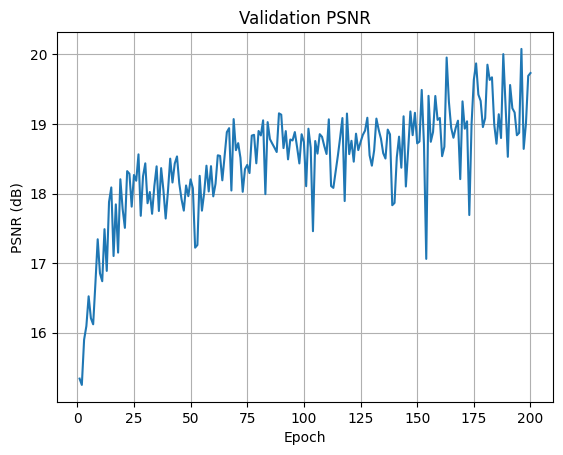

In [28]:
# Validation PSNR
plt.plot(epochs, val_psnr)
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title('Validation PSNR')
plt.grid(True)
plt.savefig('RRDB_SE_CHECKPOINTS_gaussian_blur/validation_psnr.png', dpi=300, bbox_inches='tight')

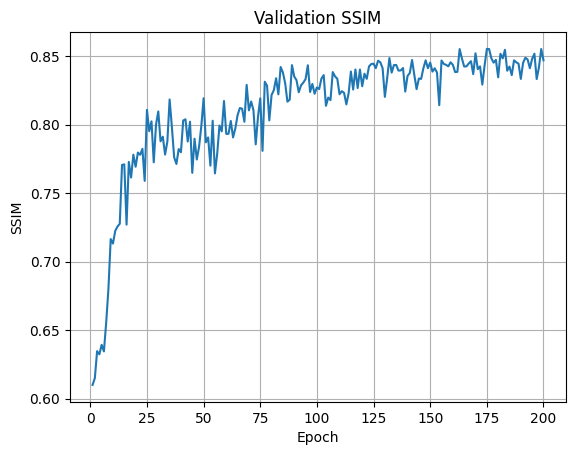

In [29]:
# Validation SSIM

plt.plot(epochs, val_ssim)
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.title('Validation SSIM')
plt.grid(True)
plt.savefig('RRDB_SE_CHECKPOINTS_gaussian_blur/validation_ssim.png', dpi=300, bbox_inches='tight')

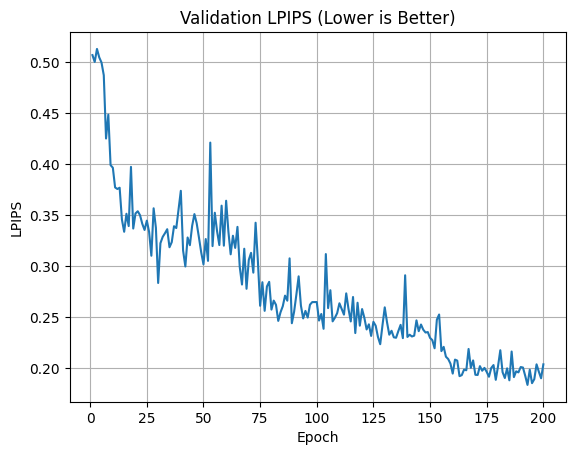

In [30]:
# Validation LPIPS
plt.plot(epochs, val_lpips)
plt.xlabel('Epoch')
plt.ylabel('LPIPS')
plt.title('Validation LPIPS (Lower is Better)')
plt.grid(True)
plt.savefig('RRDB_SE_CHECKPOINTS_gaussian_blur/validation_lpips.png', dpi=300, bbox_inches='tight')

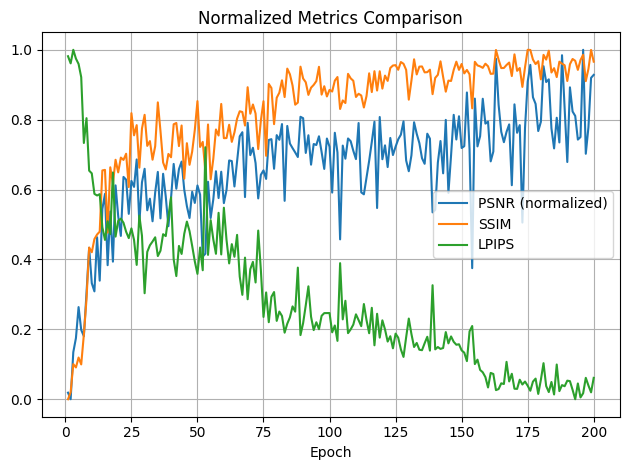

In [31]:
# Combined Metrics
val_psnr_norm = (np.array(val_psnr)-np.min(val_psnr))/(np.max(val_psnr)-np.min(val_psnr))
val_ssim_norm = (np.array(val_ssim)-np.min(val_ssim))/(np.max(val_ssim)-np.min(val_ssim))
val_lpips_norm = (np.array(val_lpips)-np.min(val_lpips))/(np.max(val_lpips)-np.min(val_lpips))

plt.plot(epochs, val_psnr_norm, label='PSNR (normalized)')
plt.plot(epochs, val_ssim_norm, label='SSIM')
plt.plot(epochs, val_lpips_norm, label='LPIPS')
plt.xlabel('Epoch')
plt.title('Normalized Metrics Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('RRDB_SE_CHECKPOINTS_gaussian_blur/training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

### TESTING ON REAL WORLD IMAGES (CAPTURED BY US)

In [32]:
generator = Generator().to(device)
# Load model with explicit CPU mapping
generator.load_state_dict(torch.load("RRDB_SE_CHECKPOINTS_gaussian_blur/best_model.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [33]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image
import io
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Set device (automatically handles CPU/GPU)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

# Image transformations
transform = transforms.Compose([
    transforms.Resize((225, 225)),
    transforms.ToTensor()
])

# Create file upload widget
upload_widget = widgets.FileUpload(accept='image/*', multiple=False)

def on_upload_change(change):
    clear_output(wait=True)
    display(upload_widget)

    # Load model with proper device mapping
    generator = Generator().to(device)
    state_dict = torch.load("RRDB_SE_CHECKPOINTS_gaussian_blur/best_model.pth", map_location=device)
    # generator.load_state_dict(state_dict['generator'], strict=False)
    generator.load_state_dict(state_dict) # use this for best model.pth

    # Process uploaded image - NEW WAY to handle file upload
    if not upload_widget.value:
        return

    for filename, file_info in upload_widget.value.items():
        image_bytes = file_info['content']
        pil_image = Image.open(io.BytesIO(image_bytes)).convert('RGB')

        # Transform and process
        input_tensor = transform(pil_image).unsqueeze(0).to(device)

        generator.eval()
        with torch.no_grad():
            enhanced_tensor = generator(input_tensor)

        enhanced_tensor = torch.clamp(enhanced_tensor, 0, 1).cpu().squeeze(0)
        enhanced_image = transforms.ToPILImage()(enhanced_tensor)

        # Display results
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.imshow(pil_image)
        plt.title("Original Low-Light")
        plt.axis("off")

        plt.subplot(1,2,2)
        plt.imshow(enhanced_image)
        plt.title("Enhanced High-Light")
        plt.axis("off")

        plt.show()



In [34]:
def on_upload_change(change):
    clear_output(wait=True)
    display(upload_widget)

    # Load model (with flexible state_dict handling)
    generator = Generator().to(device)
    state_dict = torch.load("RRDB_SE_CHECKPOINTS_gaussian_blur/best_model.pth", map_location=device)
    if isinstance(state_dict, dict) and 'generator' in state_dict:
        generator.load_state_dict(state_dict['generator'], strict=False)
    else:
        generator.load_state_dict(state_dict, strict=False)

    # Handle new FileUpload value format (tuple of dictionaries)
    if not upload_widget.value:
        return
    
    # Get first uploaded file (even if multiple=False)
    uploaded_file = upload_widget.value[0]  # Gets first tuple element
    
    # Process the image
    image_bytes = uploaded_file['content']
    pil_image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
    
    # Transform and process
    input_tensor = transform(pil_image).unsqueeze(0).to(device)
    
    generator.eval()
    with torch.no_grad():
        enhanced_tensor = generator(input_tensor)
    
    enhanced_tensor = torch.clamp(enhanced_tensor, 0, 1).cpu().squeeze(0)
    enhanced_image = transforms.ToPILImage()(enhanced_tensor)
    
    # Display results
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(pil_image)
    plt.title("Original Low-Light")
    plt.axis("off")
    
    plt.subplot(1,2,2)
    plt.imshow(enhanced_image)
    plt.title("Enhanced High-Light")
    plt.axis("off")
    
    plt.show()

In [35]:
# Display and observe
display(upload_widget)
upload_widget.observe(on_upload_change, names='value')

FileUpload(value=(), accept='image/*', description='Upload')

In [36]:
# Display and observe
display(upload_widget)
upload_widget.observe(on_upload_change, names='value')

FileUpload(value=(), accept='image/*', description='Upload')

In [37]:
# Display and observe
display(upload_widget)
upload_widget.observe(on_upload_change, names='value')

FileUpload(value=(), accept='image/*', description='Upload')

In [38]:
# Display and observe
display(upload_widget)
upload_widget.observe(on_upload_change, names='value')

FileUpload(value=(), accept='image/*', description='Upload')

In [39]:
# Display and observe
display(upload_widget)
upload_widget.observe(on_upload_change, names='value')

FileUpload(value=(), accept='image/*', description='Upload')